In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.integrate as integrate

**See first:** [Sampling](./1_sampling.ipynb) and [LotUS](./2_lotus.ipynb)

## 1. Understanding conditioning

A cohort of $N=100$ students sat an exam. We know that the marks are distributed according to the Beta distribution (scaled to 100 marks) with parameters $\alpha=4$ and $\beta=2.5$. The expected value of the mark, $X$, is
$${\rm I\!E}[X] = \frac{\alpha}{\alpha+\beta}\cdot 100 \approx 61.538.$$

In [ ]:
np.random.seed(1)
num_students = 100
alpha = 4
beta = 2.5
marks = 100 * np.random.beta(alpha, beta, size=num_students)

# Unconditional mean
mean_uncond = marks.mean()
print(f"The unconditional (sample) mean is {mean_uncond:.2f}")

# Increase the number of students and see what happens

The unconditional (sample) mean is 62.51


**Exercise:** Make a histogram of the marks with 10 bins

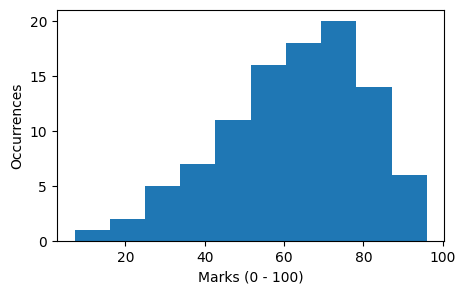

In [ ]:
# Your code goes here
plt.figure(figsize=(5, 3))
plt.hist(marks, bins=10)
plt.xlabel("Marks (0 - 100)")
plt.ylabel("Occurrences")
plt.show()

Suppose a student has found out that they have passed (their mark is at least 50), but they don't know their exact mark. Suppose they don't know that $X$ follows the Beta distribution, but they have the above data (of marks). What is their expected mark?

In [ ]:
# Conditional mean **GIVEN** that the mark is above 50
mean_cond = marks[marks >= 50].mean()
print(f"The conditional sample mean is {mean_cond:.2f}")

The conditional sample mean is 69.74


What is the theoretical value of the conditional expected mark?

The conditional expectation is
$${\rm I\!E}[X | X \geq 50] = \frac{{\rm I\!E}[X 1_{\geq 0.5}(X)]}{P[X \geq 0.5]} = \frac{\int_{0.5}^{1} x p_X(x) dx}{1 - F_X(0.5)}$$

The cdf of the Beta distribution, $F_X(0.5)$, can be computed with `stats.beta.cdf` as follows

In [ ]:
prob_x_leq_50 = stats.beta.cdf(0.5, alpha, beta)

We will determine the integral numerically in Python using `scipy.integrate.quad`.

In [ ]:
my_integrand = lambda x: x * stats.beta.pdf(x, alpha, beta)
integral = integrate.quad(my_integrand, 0.5, 1)[0]
cond_expectation_theoretical = 100 * integral / (1 - prob_x_leq_50)
print(f"E[X | X ≥ 50] = {cond_expectation_theoretical:.2f} (theoretical)")

E[X | X ≥ 50] = 69.87 (theoretical)


## 3. Conditioning of multivariate normal distributions

Let $X \sim \mathcal{N}(\mu, \Sigma)$ be an $n$-dimensional random vector. Let us partition $X$ into two random vectors $X_1$ and $X_2$ as
$$X = \begin{bmatrix}X_1\\X_2\end{bmatrix},$$
with $X_1 \in {\rm I\!R}^{n_1}$, $X_2 \in {\rm I\!R}^{n_2}$ with $n = n_1 + n_2$.
Let
$$\mu=\begin{bmatrix}\mu_1\\\mu_2\end{bmatrix}, \text{and } \Sigma = \begin{bmatrix}\Sigma_{11} & \Sigma_{12}\\\Sigma_{21} & \Sigma_{22}\end{bmatrix},$$
and assume that $\Sigma_{22}\in\mathbb{S}_{++}^{n_2}$. Then, the conditional distribution of $X_1$ given that $X_2 = x_2$ is normal with mean
$${\rm I\!E}[X_1 {}\mid{} X_2 = x_2] {}={} \mu_1 + \Sigma_{12}\Sigma_{22}^{-1}(x_2 - \mu_2),$$
and
$${\rm Var}[X_1{}\mid{} X_2 = x_2] {}={} \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1} \Sigma_{21}.$$
Let us look at a few examples.

### 3.1. Example 1

Suppose $X_1$ and $X_2$ are univariate and ${\rm I\!E}[X_1] = 1$, ${\rm I\!E}[X_2] = 2$, ${\rm Var}[X_1] = 3$, ${\rm Var}[X_2] = 4$, ${\rm Cov}[X_1, X_2] = 0.8$.

We will determine ${\rm I\!E}[X_1 {}\mid{} X_2 = x_2]$ (which is a function of $x_2$) and ${\rm Var}[X_1 {}\mid{} X_2 = x_2]$.

In [ ]:
mu_1, mu_2 = 1, 2
var_11, var_22 = 3, 4
var_12 = 0.8

# The conditional expectation of X1 given that X2 is
cond_exp_x1_given_x2 = lambda x2: mu_1 + var_12 / var_22 * (x2 - mu_2)

# The conditional variance of X1 given X2 is
cond_var_x1_given_x2 = var_11 - var_12**2 / var_22
print(f"The conditional variance of X1 given X2 is {cond_var_x1_given_x2:.2f}")
# Note that cond_var_x1_given_x2 < var_11

The conditional variance of X1 given X2 is 2.84


**Estimation:** We can use the conditional expectation of $X_1$ given $X_2$ as an estimator of $X_1$. In the next section we'll see that this is a great estimator.

In [ ]:
# Example 1 (cont'd)
# Estimate X1 given that X2 = 5
x1est = cond_exp_x1_given_x2(5)
print(f"Given X2 = 5 we estimate X1 = {x1est:.2f}")
print(f"We have (X1 | X2 = 5) ~ N({cond_exp_x1_given_x2(5):.2f}, {cond_var_x1_given_x2:.2f})")

Given X2 = 5 we estimate X1 = 1.60
We have (X1 | X2 = 5) ~ N(1.60, 2.84)


### 3.2. Example 2

Now suppose $X_1$ and $X_2$ are as follows
$$X_1 \sim \mathcal{N}\left(\begin{bmatrix}1\\2\\3\end{bmatrix}, \begin{bmatrix}10 & 0.5 & 1\\ 0.5 & 4 & -1\\1 & -1 & 6\end{bmatrix}\right),$$
and
$$X_2 \sim \mathcal{N}\left(\begin{bmatrix}4\\5\end{bmatrix}, \begin{bmatrix}1 & -0.2\\ -0.2 & 1.5\end{bmatrix}\right),$$
and
$${\rm Cov}(X_1, X_2) = \begin{bmatrix}1 & -1 \\ 0.7 & -0.6 \\ 2 & 1\end{bmatrix}.$$
Determine $X_1 {}\mid{} X_2 = x_2$.

In [ ]:
mu_1 = np.array([[1, 2, 3]]).T
mu_2 = np.array([[4, 5]]).T
S11 = np.array([[10, 0.5, 1], [0.5, 4, -1], [1, -1, 6]])
S22 = np.array([[1, -0.2], [-0.2, 1.5]])
S12 = np.array([[1, -1], [0.7, -0.6], [2, 1]])

# The conditional expectation of X1 given that X2 = x2 is
cond_exp_x1_given_x2 = lambda x2: mu_1 + S12 @ np.linalg.solve(S22, x2 - mu_2)
cond_var_x1_given_x2 = S11 - S12 @ np.linalg.solve(S22, S12.T)

Now let us estimate $X_1$ given that $X_2 = (4.5, 4)$.

In [ ]:
cond_exp_x1_given_x2_0 = cond_exp_x1_given_x2(np.array([[4.5, 4]]).T)
print("X1 | X2 = (4.5, 4) ")
print(cond_exp_x1_given_x2_0)

X1 | X2 = (4.5, 4) 
[[1.99315068]
 [2.63356164]
 [3.1369863 ]]


## 3. The conditional expectation as an estimator

**What is an estimator?** An estimator of a random variable $X$ given a random variable $Y$ is a function $\widehat{X}(Y)$. An estimator is a random variable itself. A good estimator $\widehat{X}$ is as close as possible to $X$ (in some sense).

The conditional expectation has the following desired properties:
1. It is unbiased, i.e., ${\rm I\!E}[{\rm I\!E}[X | Y]] = {\rm I\!E}[X]$.
2. It is a minimum variance estimator



**See next:** [Tutorial](./4_tutorial.ipynb)